In [36]:
# Import Libraries

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import export_text
from sklearn.preprocessing import MinMaxScaler


In [37]:
# Read in Data from CSV
raw_data = np.genfromtxt("lk_pressed.csv", delimiter=',')
# Convert Integer Time to Float ime
# Since we will have several readings with the same time in the csv, 
# we have to split these up by millisecond intervals
# If we have five readings at 67 seconds, we will split them up into 5 time slots
# 67.0, 67.2, 67.4, 67.6, 67.8


running_list_x = []
running_list_y = []
# Final values to be stored in the DataFrame
final_x = []
final_y = []

# Create a MinMaxScaler instance
scaler = MinMaxScaler()


prev = 0
total = 0
for x,y in raw_data:
    
    # if the times are the same, then we append the vals to a running list
    if x == prev:
        running_list_x.append(x)
        running_list_y.append(y)

    # if the times are different, then we can break up the 
    # millisecond based on how many sensor readings we got
    else:
        for index, i in enumerate(running_list_x):
            final_x.append(min(running_list_x) + (index + 1) / len(running_list_x))
            final_y.append(running_list_y[index])
        running_list_x = []
        running_list_y = []
    prev = x
    


# Normalize the final_y values
final_y = np.array(final_y).reshape(-1, 1)  # Reshape to 2D
final_y = scaler.fit_transform(final_y).flatten()  # Flatten back to 1D

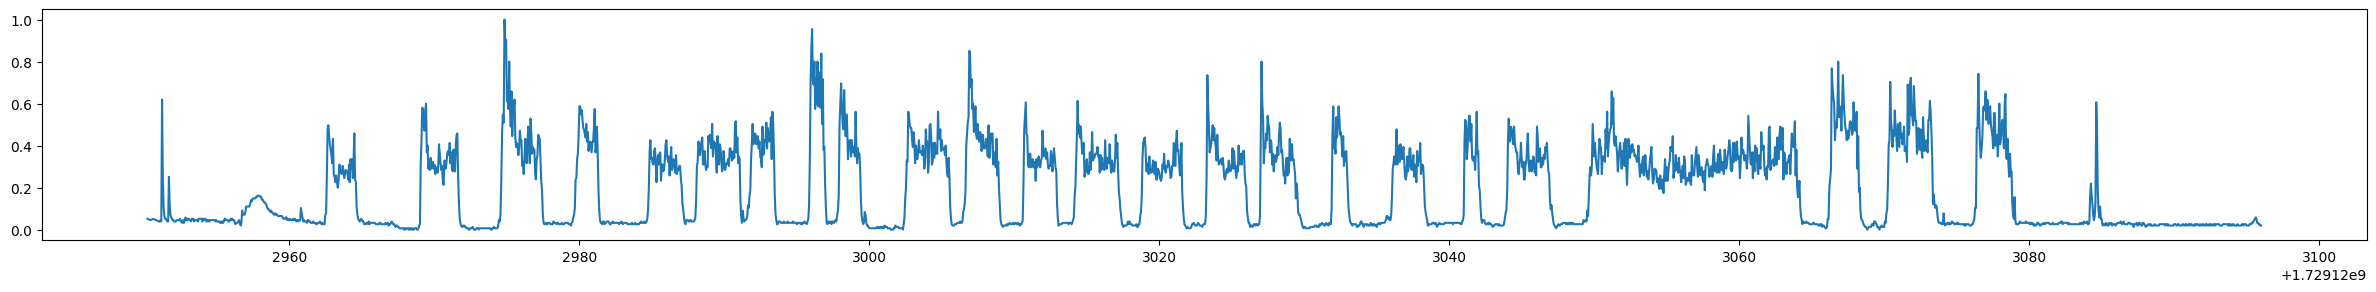

,Time,Signal
174,0.000000,0.051613
175,0.052632,0.045161
176,0.105263,0.045161
177,0.157895,0.045161
178,0.210526,0.051613


2572


In [38]:
# Initial Plot
plt.figure(figsize=(30, 3))
plt.plot(final_x, final_y)
plt.show()

# Create a Pandas DataFrame
orignal = pd.DataFrame({"Time": final_x[1:], "Signal": final_y[1:]})

# Filter out data before the start time
df = orignal[orignal["Time"] > 1729122960].copy()

#Standardize time so the first point is at 0 seconds
df["Time"] = df["Time"] - min(df["Time"])

# Print
display(df.head())
print(len(df))

In [39]:
#Known open and closed intervals
interval_times = [2.34, 2.14, 4.24, 2.72, 2.94, 2.81,
                  2.39, 1.71, 3.36, 2.39, 0.93, 2.89,
                  0.73, 1.54, 2.37, 1.14, 0.79, 1.59,
                  3.06, 3.11, 1.09, 2.29, 1.59, 2.28,
                  1.31, 3.02, 1.48, 2.84, 1.66, 2.86,
                  0.93, 2.56, 2.36, 1.18, 2.94, 2.29,
                  2.67, 1.41, 1.48, 3.11, 2.92, 14.24,
                  2.23, 1.96, 2.08, 3.12, 2.87, 2.31,
                  2.29]

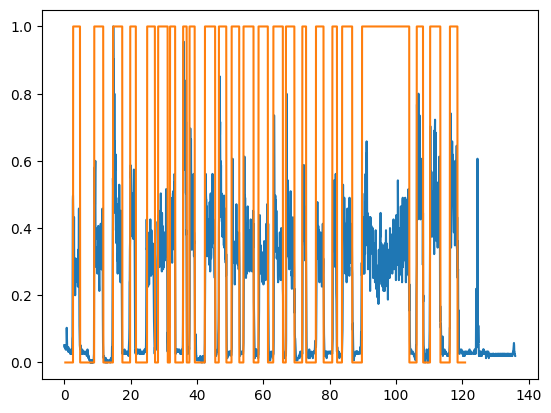

In [40]:
# Throw out data before here
start_time = 0.3

# Label each point with a State based on the interval
for i in range(len(interval_times)):
    
    end_time = start_time + interval_times[i]
    
    df.loc[df["Time"].between(start_time, end_time), "State"] = i%2
            
    start_time = end_time
    
# Plot Data
plt.plot(df["Time"], df["Signal"])
plt.plot(df["Time"], df["State"])

# Removes any numbers which are infinity or NaN
df = df[df["State"].apply(lambda x: not (pd.isna(x) or x in [float('inf'), float('-inf')]))]

plt.show()

In [42]:
def percentile20(data):
    return np.percentile(data,20)


def skew(data):
    mean = np.mean(data)
    std = np.std(data)
    N = np.size(data)
    top = np.sum((data - mean)**3)
    bottom = (N-1)*(std**3)
    total = top/(bottom + 0.0000001)
    return total

def kurtosis(data):
    mean = np.mean(data)
    top = np.sum((data - mean)**4)
    bottom = np.sum((data - (mean)**2)**2)
    total = top/(bottom + 0.00000001)
    return total

def stdfd(data):
    difference = np.diff(data)
    std = np.std(difference)
    return std

In [ ]:
slice_length = 10

mean_list = []
max_list = []
min_list = []
range_list = []
last_list = []
second_list = []
perc_list = []
skew_list = []
kurt_list = []
stdiff_list = []
state_list = []

# Take slice_length number of signal points
for i in range(0, len(df) - slice_length + 1):
    current_frame = df.iloc[i: i + slice_length - 1]
    
    #plt.figure(figsize = (6,4))
    
    # Standard features
    mean_list.append(current_frame[ "Signal" ].mean())
    max_list.append(current_frame[ "Signal" ].max())
    min_list.append(current_frame[ "Signal" ].min())
    range_list.append(current_frame[ "Signal" ].max() - current_frame[ "Signal" ].min())
    
    perc_list.append(percentile20(current_frame[ "Signal" ]))
    skew_list.append(skew(current_frame[ "Signal" ]))
    kurt_list.append(kurtosis(current_frame[ "Signal" ]))
    stdiff_list.append(stdfd(current_frame["Signal"]))
    

    # Other features of interest
    last_list.append(current_frame.iloc[-1]["Signal"])
    second_list.append(current_frame.iloc[-2]["Signal"])
    
    # State, Y
    state_list.append(current_frame.iloc[-1]["State"])
    
# Make feature df for random forest
feature_df = pd.DataFrame({"Mean": mean_list, 
                           "Max": max_list, 
                           "Min": min_list, 
                           "Range": range_list,
                           "Last Val": last_list, 
                           "2nd Last Val": second_list, 
                           "Percentile": perc_list,
                           "Skew": skew_list,
                           "Kurtosis": kurt_list,
                           "Stdiff": stdiff_list,
                           "State": state_list
                          })


print (feature_df.head(200))

         Mean       Max       Min     Range  Last Val  2nd Last Val  \
0    0.050896  0.103226  0.038710  0.064516  0.103226      0.045161   
1    0.053763  0.103226  0.038710  0.064516  0.077419      0.103226   
2    0.055197  0.103226  0.038710  0.064516  0.058065      0.077419   
3    0.055197  0.103226  0.038710  0.064516  0.038710      0.058065   
4    0.055197  0.103226  0.038710  0.064516  0.045161      0.038710   
..        ...       ...       ...       ...       ...           ...   
195  0.344086  0.412903  0.290323  0.122581  0.316129      0.412903   
196  0.348387  0.412903  0.290323  0.122581  0.367742      0.316129   
197  0.344086  0.412903  0.283871  0.129032  0.283871      0.367742   
198  0.342652  0.412903  0.277419  0.135484  0.277419      0.283871   
199  0.348387  0.412903  0.277419  0.135484  0.380645      0.277419   

     Percentile      Skew  Kurtosis    Stdiff  State  
0      0.042581  2.581424  0.000312  0.020145    0.0  
1      0.042581  1.767023  0.000237  

In [45]:
# Features and target
X = feature_df[["Mean", "Max", "Min", "Range", "Last Val", "2nd Last Val", "Percentile", "Skew", "Kurtosis", "Stdiff"]]  # Features
y = feature_df["State"]  # Target
y = y.astype(int)


# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# Make random forest
model = RandomForestClassifier(random_state=42, max_features = "sqrt", max_depth = 6)
model.fit(X_train, y_train)


# Use test test for prediction
y_pred = model.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Feature importance
importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": model.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("\nFeature Importance:")
print(importance)

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       288
           1       0.97      0.95      0.96       394

    accuracy                           0.95       682
   macro avg       0.95      0.95      0.95       682
weighted avg       0.95      0.95      0.95       682

Confusion Matrix:
[[275  13]
 [ 20 374]]

Feature Importance:
        Feature  Importance
4      Last Val    0.315339
5  2nd Last Val    0.240278
0          Mean    0.160164
1           Max    0.096250
2           Min    0.064778
6    Percentile    0.063809
3         Range    0.017051
9        Stdiff    0.016980
8      Kurtosis    0.016706
7          Skew    0.008646


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       197
           1       0.97      0.96      0.97       258

    accuracy                           0.96       455
   macro avg       0.96      0.96      0.96       455
weighted avg       0.96      0.96      0.96       455

Confusion Matrix:
[[190   7]
 [ 10 248]]
Coefficients: [[ 3.13192168  2.11402194  3.38571455 -1.27169261  5.6220397   4.02977679
   3.23923276  0.19518837 -0.08328167 -0.05562425]]
Intercept: [-3.64894396]
log(p/(1-p)) = -3.65 + 3.13 * x1 + 2.11 * x2 + 3.39 * x3


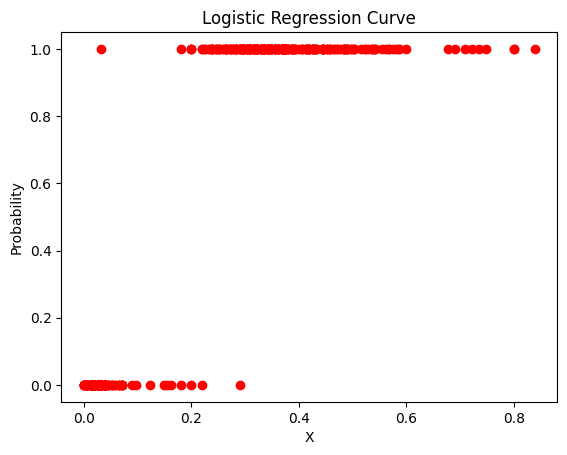

In [54]:
from sklearn.linear_model import LogisticRegression


# Features and target
logistic_X = feature_df[["Mean", "Max", "Min", "Range", "Last Val", "2nd Last Val", "Percentile", "Skew", "Kurtosis", "Stdiff"]]  # Features
logistic_y = feature_df["State"]  # Target
logistic_y = logistic_y.astype(int)


# Split data
logistic_X_train, logistic_X_test, logistic_y_train, logistic_y_test = train_test_split(logistic_X, logistic_y, test_size=0.2, random_state=42)

# Make logistic
logistic_model = LogisticRegression()
logistic_model.fit(logistic_X_train, logistic_y_train)


# Use test test for prediction
logistic_y_pred = model.predict(logistic_X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(logistic_y_test, logistic_y_pred))

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(logistic_y_test, logistic_y_pred))

print("Coefficients:", logistic_model.coef_)
print("Intercept:", logistic_model.intercept_)

#Extract coefficients and intercept
coefficients = logistic_model.coef_[0]
intercept = logistic_model.intercept_[0]

# Construct the equation
equation = f"log(p/(1-p)) = {intercept:.2f} + {coefficients[0]:.2f} * x1 + {coefficients[1]:.2f} * x2 + {coefficients[2]:.2f} * x3"
print(equation)

# Plot the logistic regression curve
plt.scatter(logistic_X_test["Last Val"], logistic_y_pred, color='red')
plt.xlabel('X')
plt.ylabel('Probability')
plt.title('Logistic Regression Curve')
plt.show()


In [47]:
# Assuming your RandomForest model is already trained
# Extract the first decision tree from the Random Forest
tree = model.estimators_[0]

# Get the decision rules for the tree
tree_rules = export_text(tree, feature_names=X.columns.tolist())

# Print the decision rules (splits and thresholds used in the first tree)
print(tree_rules)

|--- Last Val <= 0.14
|   |--- Percentile <= 0.11
|   |   |--- Skew <= 2.39
|   |   |   |--- Stdiff <= 0.10
|   |   |   |   |--- 2nd Last Val <= 0.04
|   |   |   |   |   |--- Max <= 0.47
|   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |--- Max >  0.47
|   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |--- 2nd Last Val >  0.04
|   |   |   |   |   |--- Mean <= 0.03
|   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |--- Mean >  0.03
|   |   |   |   |   |   |--- class: 0.0
|   |   |   |--- Stdiff >  0.10
|   |   |   |   |--- Max <= 0.51
|   |   |   |   |   |--- class: 1.0
|   |   |   |   |--- Max >  0.51
|   |   |   |   |   |--- class: 0.0
|   |   |--- Skew >  2.39
|   |   |   |--- Mean <= 0.03
|   |   |   |   |--- class: 1.0
|   |   |   |--- Mean >  0.03
|   |   |   |   |--- class: 0.0
|   |--- Percentile >  0.11
|   |   |--- Max <= 0.36
|   |   |   |--- class: 1.0
|   |   |--- Max >  0.36
|   |   |   |--- Range <= 0.44
|   |   |   |   |--- class: 0.0
|   |   |